<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Importing dependencies and define helper functions

In [272]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm
from gym.wrappers import RecordVideo

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Task 1: Development of an RL agent

### Task 1: Deep Q Network RL Agent ###
referenced from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

#### DEEP Q-Network (DQN) ####

##### Constructor #####

__n_observations__ : Size of observation space (input size), number of features observed from environment at each timestamp
__n_actions__ : Size of action space (ouput size), number of possible actions the agent can take

__self.layer1__ : takes the input (observation) and transforms it into a 128-dimensional space <br>
__self.layer2__ : hidden layer which operates on the 128-dimensional space and outputs another 128-dimensional space <br>
__self.layer3__ : transforms the output of __layer2__ into the action space size, producing a vlue for each possible action

##### Forward Pass #####

1. __forward__ takes an input tensor __x__ (observations) 
2. Passes __x__ through __layer1__ and applies the ReLu activation function (__F.relu__) to the output
3. Ouput is then pass through __layer2__ and another ReLu activation function 
4. Output of __layer2__ is passed through __layer3__ which maps it to the action space and returned without any activation function (output represents expected rewards for each action)<br>

Output of __forward__ method is a tensor where each element corresponds to a predicted value (Q-value) of taking an action given the current observation and used by the agent to decide which action to take next


In [273]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#### Replay Memory ####

##### Transition #####
__Transition__ is a __namedtuple__ which represents a single transition in the environment and is essentially a timestamp of the agent's interaction with the environment and includes:
- __state__ : observation of enivronment before taking the action
- __action__ : action taken by the agent
- __next_state__ : obeservation of environment after taking the action
- __reward__ : reward received after taking the action

In [274]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

##### Constructor #####
Takes a single argument __capacity__ which is the maximum number of transitions the replay memory can hold and initialises a __deque__ (double-ended queue) with a fixed maximum length of __capacity__. This __deque__ automatically removes the oldest element when new transitions are added beyond its capacity, ensuring memory size never exceeds the specifieid limit

##### Push #####
Apends a new __Transition__ object to the __memory__ deque

##### Sample #####
Randomly samples a batch of transitions from the memory, where __batch_size__ specifies how many transitions to sample, allowing the DQN to learn from a random sample of past experiences, reducing correlation between consecutive training samples and stabilises training

In [275]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def add(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#### Environment Initialisation ####

In [276]:
env = gym.make('CartPole-v1').unwrapped
env.reset()

(array([-0.04404246,  0.00477466,  0.00630126,  0.03452177], dtype=float32),
 {})

##### Hyperparameters #####
__BATCH_SIZE__ : Number of training examples used in one iteration to update the network's weights <br>
__GAMMA__ : Discount factor for future rewards, influencing how much the agent values immediate rewards over future rewards <br>
__EPS_START__, __EPS_END__, __EPS_DECAY__ : Parameters for epsilon-greedy strategy <br>
__TAU__ : Parameter used for soft update of the target network's weights <br>
__LR__ : Learning rate for optimiser <br>

##### Network Initialisation #####
__n_actions__ & __n_observations__ : Determines size of action space and shape of obervation space respectively

__policy_net__ : Neural network used to determine action to take at each step

__target_net__ : A copy of the policy network which helps in stabilising training. It is updated less frequently to provide a stable target for optimising the policy network

##### Optimiser #####
Defines the optimisation algorithm used to update the weights of the policy network (AdamW). __amsgrad=True__ is a variant of the Adam optimiser which can lead to better convergence in some cases

##### Replay Memory #####
Initialises replay memory with a caopacity of 10000 transitions

##### Steps counter #####
Keeps track of the total number of actions the agent has taken

In [277]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

#### Optimiser ####

In [278]:
def optimize_model():
    # Checks if there are enough transitions stored in the replay memory to sample a batch.
    # If not, returns immediately without performing optimisation
    if len(memory) < BATCH_SIZE:
        return
    
    # Samples a batch of transition from the replay memory and restructures this batch
    # Converts the batch from a list of "Transition" namedtuples into a single "Transition" namedtuple
    # where each attribute contain all corresponding elements from the batch
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Processes the batch to separate final and non-final states
    # A mask is created to identify non-final states
    # States, actions & rewards concatenated into tensors for batch processing
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Calculates the Q-values predcited by the "policy_net" for the actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Calculates the expected Q-values for the next states using the "target_net"
    # Only does this for non_final states
    # Calculated based on the maximum Q-value predicted for the next states following the Bellman equation
    # adjusted by reward received and discount factor (GAMMA)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Loss between predicted Q-values "state_action_values" and expected Q-values "expected_state_action_values"
    # computed using the Huber Loss (Smooth L1 Loss)
    # which is less sensitive to outliers than squared error loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Gradient of loss with respect ot network parameters calculated using backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # Optimiser updates network parameters based on gradients
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

#### Epsilon Greedy Strategy ####

In [279]:
def select_action(state):
    # Epsilon Threshold Calculation
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    # Action Selection
    if random.random() > eps_threshold:
        with torch.no_grad():
            # Select action with highest Q-value
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Select random action
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

#### Main Training Loop ####

In [280]:
# Constants
number_of_episodes = 1000  # For DQN simulation learning
gamma = 0.99  # Discount factor
epsilon_start = 1.0  # Starting value of epsilon for exploration
epsilon_end = 0.01  # Minimum value of epsilon
epsilon_decay = 200  # Rate at which to decay epsilon
batch_size = 128  # Batch size for replay memory sampling
target_update = 10  # How often to update the target network

# Initialize environment
env = gym.make('CartPole-v1')

# Get number of actions and observations from the environment
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

# Initialize policy and target networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # Set target net to evaluation mode

# Optimizer and Replay Memory
optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(10000)

# Function to update epsilon
def epsilon_by_episode(episode):
    return epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * episode / epsilon_decay)

all_episodes_reward = []

for episode in tqdm(range(number_of_episodes)):
    env_state, _ = env.reset()
    state = torch.tensor([env_state], device=device, dtype=torch.float)
    total_reward = 0
    epsilon = epsilon_by_episode(episode)
    done = False
    
    while not done:
        action = select_action(state)
        next_state, reward, done, _, _ = env.step(action.item())
        total_reward += reward
        
        if total_reward > 500:  # Condition to stop the episode if reward exceeds 500
            break  # Breaks out of the while loop, ending the episode
        
        if not done:
            next_state_tensor = torch.tensor([next_state], device=device, dtype=torch.float)
        else:
            next_state_tensor = None
        
        # Store the transition in memory
        reward_tensor = torch.tensor([reward], device=device)
        memory.add(state, action, next_state_tensor, reward_tensor)
        
        # Move to the next state
        state = next_state_tensor
        
        # Perform one step of the optimization
        optimize_model()
        
    all_episodes_reward.append(total_reward)
    
    # Update the target network
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

env.close()

100%|██████████| 1000/1000 [04:03<00:00,  4.10it/s]


The code below shows the agent's decision for a given observation.

In [281]:
# Sample a random state from the environment
random_state = env.observation_space.sample()
state_tensor = torch.tensor([random_state], device=device, dtype=torch.float)

# Choose action based on the randomly sampled state
action = select_action(state_tensor)

# Print the state and chosen action
print(f"Sampled State: {random_state}")
print(f"Chosen Action: {action.item()}")

# Close the environment
env.close()

Sampled State: [ 6.9231093e-01  2.9461924e+38  4.0015143e-01 -1.1935672e+38]
Chosen Action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

Here we run the agent again for 100 times, and append the reward for each round to a list.

100%|██████████| 100/100 [00:02<00:00, 47.27it/s]

Average Reward over 100 episodes: 496.15


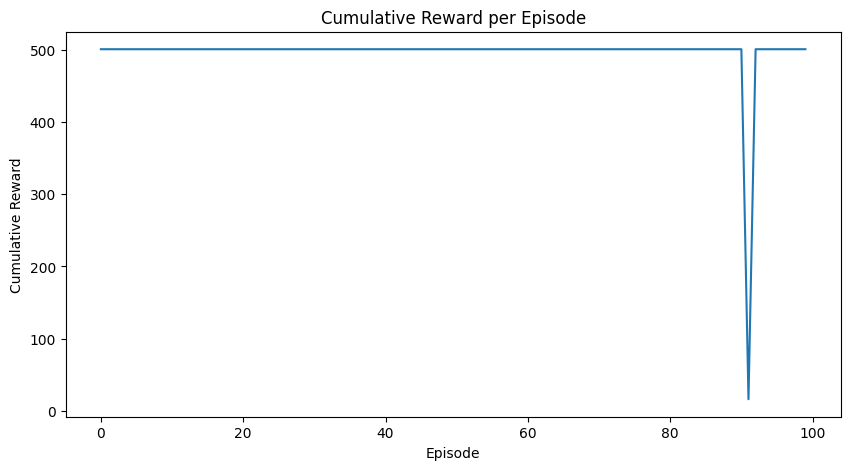

In [282]:
def run_episodes(env, policy_net, n_episodes=100):
    rewards = []
    for episode in tqdm(range(n_episodes)):
        # Adjusting for the new env.reset() return values
        state, _ = env.reset()
        state = torch.tensor([state], device=device, dtype=torch.float)
        episode_reward = 0
        done = False
        while not done:
            action = select_action(state)
            # Adjusting for the new env.step(action) return values
            next_state, reward, done, _, _ = env.step(action.item())
            episode_reward += reward
            
            if episode_reward > 500:  # Check if the reward exceeds 500
                break  # Stop the episode and move on to the next one

            # Prepare the next state for the next iteration
            next_state = torch.tensor([next_state], device=device, dtype=torch.float)
            state = next_state

        rewards.append(episode_reward)
    return rewards

# Run episodes and collect rewards
episode_rewards = run_episodes(env, policy_net, n_episodes=100)

# Calculate and print the average reward
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Average Reward over 100 episodes: {average_reward}")

# Plotting the rewards
plt.figure(figsize=(10,5))
plt.plot(episode_rewards)
plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()

## Task 3: Render one episode played by the agent

# TASK 4: INSTRUCTION AND EXPLANATION

In building our DQN model, we have implemented a Q-network along with a replay memory system, which follows the structure outlined in https://www.baeldung.com/cs/q-learning-vs-deep-q-learning-vs-deep-q-network.

__Q-Network__: <br>
The Q-network is a neural network which takes the state of the environment as input and outputs the expected reward for each possible action. This is the decision mkaing part of our mode. It starts with random guesses but gets better as it learns from the game through training.

__Replay Memory__: <br>
To help our Q-network learn, the replay memory is needed as it stores experiences (state, action, reward and new states) during teh game. Rather than learning from consecutive experiences as they happn, the model randomly samples from this memory, which can help to break any correlations in the sequence of experiences and leads to more stable learning.

By combining the 2, we ensure that our model learns from more than the most recent experience but benefits from past expereinces as well, leading to more effective learning. As it plays more games, it relies less on exploration and more on exploitation, which is known as epsilon decay, which was mentioned in the previous Q-learning implementation.

References:
In developing our RL agent, we referenced the PyTorch Tutoral on the implementation of DQN on both the Q-Network and Replay Memory. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html